<DIV ALIGN=CENTER>

# Introduction to Data Mining
## Professor Robert J. Brunner
  
</DIV>  
-----
-----


## Introduction

In this final IPython Notebook, we apply basic machine learning
techniques to a data set in order to extract new insights such as
classifications methodology, dimensionality reduction, or cluster
finding.

As a field, [data mining][dm] is both expansive and mathematically
complex. From deriving simple linear relationships via regression
analysis to finding clusters of data points in an $N$-dimensional space,
statistical and machine learning techniques can take years to fully
master. Given the short time available in this class, however, we will
take the simpler approach of demonstrating several basic, commonly used
approaches in order to both introduce the basic concepts and the
methodology we can use in Python to deploy them to actual data. The
standard machine learning library in Python is scikit_learn, which is
included in the Docker course image and can be imported by using the
sklearn module. In the following webpage, we can view a map detailing
the available learning methods in the sklearn module.

-----
[dm]: https://en.wikipedia.org/wiki/Data_mining

In [1]:
from IPython.display import HTML
HTML('<iframe src=http://scikit-learn.org/ width=800 height=400>     </iframe>')

-----

## Fundamentals

Machine learning techniques can be broadly classified into four
different categories:

1. [Classification][cla]: Identify which data points are in a set of
classes.

2. [Regression][re]: Identify a functional relationship between input
and output attributes.

3. [Dimensionality Reduction][dr]: Identify (and optionally rank) the
most important new dimensions for a data set.

4. [Clustering][clu]: Identify clusters of data points in an
$N$-dimensional space.

These categories are visually illustrated in the following graphic from
the scikit_learn website, along with a decision flowchart providing
guidance on what methods to apply for a particular problem.

![SKLEARN Image](http://scikit-learn.org/stable/_static/ml_map.png)

Furthermore, machine learning methods can be further classified by the
method in which they are constructed. [Supervised learning][sl] methods
use training data to build a model, which is subsequently applied to
additional data. [Unsupervised learning][ul] methods seek relationships
among data points that can be leveraged to construct a model that is
later applied to the data of interest. Often training data are used to
validate the effectiveness of an unsupervised method, or perhaps to
provide some level of supervision, which is sometimes called
[semi-supervised learning][ssl].

To begin exploring machine learning methods, we will use the classic
[_Iris_ dataset][id], which is included by default with the Seaborn
library (note this same data set is also included with scikit-learn).
First, we wil load the data set into this Notebook, and construct a pair
plot demonstrating the relationships between the different dimensions
(this code and resulting figure are also included in the Seaborn
documentation).

----

[cla]: https://en.wikipedia.org/wiki/Statistical_classification
[re]: https://en.wikipedia.org/wiki/Regression_analysis
[dr]: https://en.wikipedia.org/wiki/Dimensionality_reduction
[clu]: https://en.wikipedia.org/wiki/Cluster_analysis
[sl]: https://en.wikipedia.org/wiki/Supervised_learning
[ul]: https://en.wikipedia.org/wiki/Unsupervised_learning
[ssl]: https://en.wikipedia.org/wiki/Semi-supervised_learning
[id]: https://en.wikipedia.org/wiki/Iris_flower_data_set

In [1]:
%matplotlib notebook

In [2]:
# Set up Notebook

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Load the Iris Data
iris = sns.load_dataset("iris")

# Make pair plot
g = sns.PairGrid(iris, hue="species")
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend()

# Lets explicitly set the axes limits
axes = g.axes

lim = [(3, 9), (1.5, 5), (-2, 10), (-1, 3.5)]

for i in range(len(lim)):
    for j in range(len(lim)):
        axes[i, j].set_xlim(lim[j])
        axes[i, j].set_ylim(lim[i])

URLError: <urlopen error [Errno -2] Name or service not known>

-----

## Iris Data

As the previous figure illustrates, the three types of Iris cluster
naturally in these dimensions, with minimal overlap. As a result, these
data provide an excellent test for different machine learning
algorithms.  The four primary dimensions of the data include Sepal
Length, Sepal Width, Petal Length, and Petal Width, which can be seen
from the following Iris picture (or type _virginica_).

![Iris picture from Wikipedia](https://upload.wikimedia.org/wikipedia/commons/thumb/9/9f/Iris_virginica.jpg/220px-Iris_virginica.jpg)

The data set consists of 150 total measurements of three different types
of Iris flowers, equally divided between three classes: Iris Setosa,
Iris versicolor, and Iris virginica. Before proceeding, we can examine
the Pandas DataFrame that contains these data.

-----

In [3]:
# Exmaine the first few rows
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [4]:
# Examine grouped data
iris.groupby('species').count()

,sepal_length,sepal_width,petal_length,petal_width,species
species,,,,,
setosa,50,50,50,50,50
versicolor,50,50,50,50,50
virginica,50,50,50,50,50


-----

As demonstrated by the output from the previous code cells, our test
data  match our expectations (the full Iris data set is listed on
Wikipedia). We have three types, each with fifty entries, and every row
has four measured attributes. Before starting to apply machine learning
techniques to these data, however, we first define the following two
convenience plotting functions:

1. Confusion Matrix: this method generates a confusion matrix that
compares predicted to true values for a given data set. In our simple
example, this functions produces a 3 x 3 [heatmap][hm] since we only have
three types in our data.

2. Scatter Plot: this method display a formatted [scatter plot][sp] with each
type individually colored. This is useful for viewing the distribution
of types in a particular pair of dimensions (as shown in the original
Iris figure.

Following these function definitions, we demonstrate the scatter plot
method by producing a large version of the _Sepal Width_ versus _Petal
Width_ scatter plot.

-----

[hm]: https://en.wikipedia.org/wiki/Heat_map
[sp]: https://en.wikipedia.org/wiki/Scatter_plot

In [5]:
# Convenience function to plot confusion matrix

import numpy as np
import pandas as pd

# This method produces a colored heatmap that displays the relationship
# between predicted and actual types from a machine leanring method.

def confusion(test, predict, title):
    # Define names for the three Iris types
    names = ['setosa', 'versicolor', 'virginica']

    # Make a 2D histogram from the test and result arrays
    pts, xe, ye = np.histogram2d(test, predict, bins=3)

    # For simplicity we create a new DataFrame
    pd_pts = pd.DataFrame(pts.astype(int), index=names, columns=names )
    
    # Display heatmap and add decorations
    hm = sns.heatmap(pd_pts, annot=True, fmt="d")
    hm.axes.set_title(title)
    
    return None

# This method produces a colored scatter plot that displays the intrisic
# clustering of a particular data set. The different types are colored
# uniquely.

def splot_data(col1, col2, data, hue_col, label1, label2, xls, yls, sz=8):
    
    # Make the  scatter plot on the DataFrame
    jp = sns.lmplot(col1, col2, data,
                    fit_reg=False, hue=hue_col, size=sz, scatter_kws ={'s': 60})
    
    # Decorate the plot and set limits
    jp.set_axis_labels(label1, label2)

    jp.axes[0,0].set_xlim(xls)
    jp.axes[0,0].set_ylim(yls)

    sns.despine(offset=0, trim=True)
    sns.set(style="ticks", font_scale=2.0)

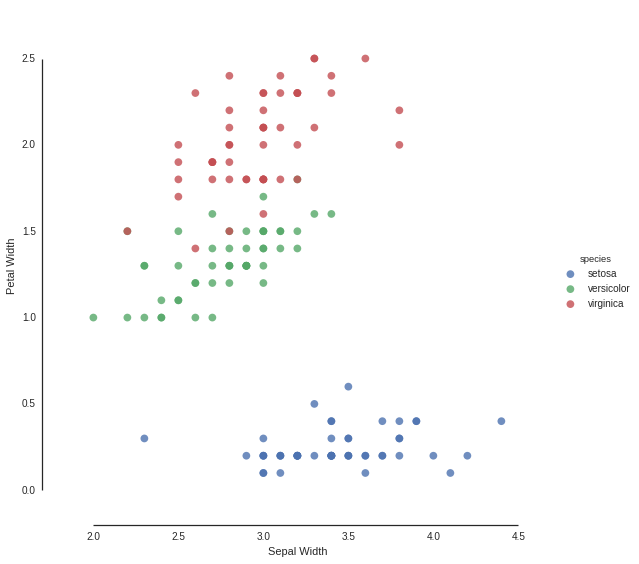

In [6]:
# Demonstration of our scatter plot method

splot_data('sepal_width', 'petal_width', iris, 'species', 
           'Sepal Width', 'Petal Width', (1.7, 4.7), (-0.2, 2.8))

-----

As the above plot clearly shows, the _setosa_ type is already separated
in these two dimensions, and the other two types: versicolor and
virginica, are nearly separated. This will simplify the task of running
and evaluating the machine learning algorithms in the rest of this
Notebook. However, this will not be the case with real data.

Our next step is to build explicit data and label NumPy arrays. We do
this primarily because scikit-learn does not work natively with Pandas
DataFrames. We can easily grab the underlying NumPy two-dimensional
array from a DataFrame by using the `values` attribute, in this case we
first select out the four attribute columns. Next, we create a numerical
array for the data types, where 0, 1, and 2 are mapped distinctly into
setosa, versicolor, and virginica.

-----

In [7]:
# Now lets get the data and labels

data = iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values
labels = np.array([i//50 for i in range(iris.shape[0])])

-----

Our final step before exploring specific machine learning algorithms is
to create training and testing data sets. We can do this by using the
`train_test_split` method in the `cross_validation` module. The only
tuning parameter at this point is the `test_size` parameter, which we
have set to 40% of our data is reserved for testing. We can change this
and study how the different algorithms perform with more or less
training data.

-----

In [8]:
# We want to split our data into training and testing

from sklearn import cross_validation

# This is the amount to hold out for 'blind' testing
frac = 0.4

d_train, d_test, l_train, l_test \
    = cross_validation.train_test_split(data, labels, test_size=frac, random_state=0)

-----

## [k-Nearest Neighbors][knn] (K-NN)

The first algorithm we will explore is one of the simplest, the
[k-nearest neighbor][knn] algorithm. Fundamentally, this algorithm is
remarkable simple and is based on the principle that data values in an
$N$- dimensional space are generally located near other similar objects.
The number of nearest neighbors, `k`, is a tuning parameter, and can be
specified a priori or in some algorithms empirically determined. The
basic principle behind k-nn is demonstrated in the following figure from
Wikipedia:

![knn Image from Wikipedia][knni]

As shown in the image, when a new datum is added, the classification
must be assigned. In the case of k-nn, this is done by looking at the
nearest neighbors and using some statistical evaluation of their
classes. For example, we could use some weighted combination of the
nearest neighbors, where the weight might be determined by the relative
distance of each neighbor from the datum of interest. 

In the following code cells, we demonstrate how to perform knn
classification by using scikit-learn. In this example, we use five
nearest neighbors (but this value can be easily adjusted to see how the
classification performance changes). The standard classification
process in scikit-learn is to first fit a model to the training data
and to subsequently apply this model to predict values for the testing
data. After this process, we first compute the prediction score before
displaying the confusion matrix for this algorithm.

-----

[knn]: https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm
[knni]: https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/KnnClassification.svg/500px-KnnClassification.svg.png

In [9]:
# First, lets try k-nearest neighbors (KNN)
from sklearn import neighbors

# The number of neighbors affects performance
nbrs = 5

# First we construct our Classification Model
knn = neighbors.KNeighborsClassifier(n_neighbors=nbrs)
# Next we train our model
knn.fit(d_train, l_train)

# Finally, we test our model
result = knn.predict(d_test)

print("KNN ({0} neighbors) prediction accuracy = {1:5.1f}%".format(nbrs, 100.0 * knn.score(d_test, l_test)))

KNN (5 neighbors) prediction accuracy =  95.0%


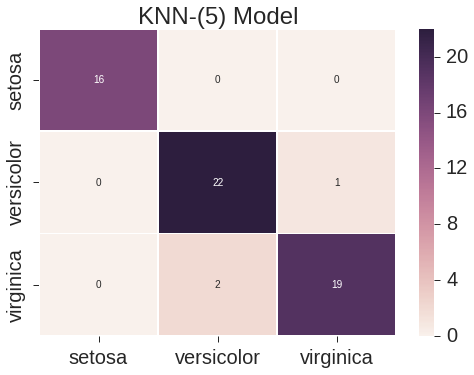

In [10]:
# Plot our confusion matrix

confusion(l_test, result, "KNN-({0}) Model".format(nbrs))

-----

## [Support Vector Machine][svm] (SVM)

The next algorithm we will demonstrate is a powerful, but simple
approach to algorithmically divide data into distinct classes.  Support
Vector Machine, or Support Vector Classification (SVC) in this case,
determine optimal hyperplanes that optimally divide the training data.
Generally we use linear hyperplanes, which results in linear SVC. This
is demonstrated in the following figure from Wikipedia, where H3 does
not divide the data into the correct two classes, H1 does divide the two
but not optimally, while H2 optimally divides the data into the two
classes.

![SVM Image from Wikipedia][svmi]

We perform linear SVC in scikit-learn by specifying a `linear` kernel
parameter when creating the classifier. Once we fit the model to the
data, we can once again use the trained model to make predictions, which
we can test by using the evaluation score and confusion matrix.

-----

[svm]: https://en.wikipedia.org/wiki/Support_vector_machine
[svmi]: https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Svm_separating_hyperplanes.png/503px-Svm_separating_hyperplanes.png

In [11]:
# Next lets try Linear SVM
from sklearn import svm

# Lets build our model and train it all at once
clf = svm.SVC(kernel='linear', C=1).fit(d_train, l_train)

# Now grab the predictions
result = clf.predict(d_test)

print("SVM prediction accuracy = {0:5.1f}%".format(100.0 * clf.score(d_test, l_test)))

SVM prediction accuracy =  96.7%


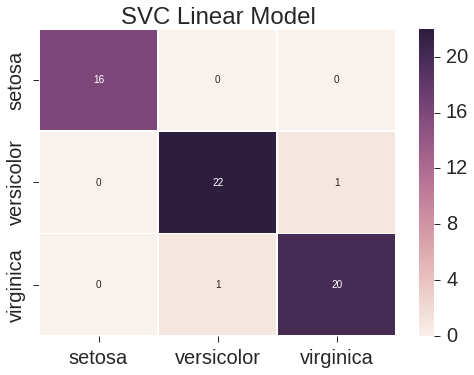

In [12]:
confusion(l_test, result, 'SVC Linear Model')

-----

## [Decision Trees][dt]

The third algorithm we will explore is the Decision Tree. A decision
tree simply asks a set of questions of the data, and based on the
answers determines the final classification. The tree is constructed by
recursively splitting a data set into new groupings based on a
statistical measure of the data along each different dimension (popular
measures include the Gini coefficient or the entropy). A basic decision
tree for the titanic survivor data set is demonstrated in the following
figure from Wikipedia (note that _sibsp_ counts the number of spouses or
siblings aboard).

![DT IMage from Wikipedia][dti]

The terminal nodes in the tree are known as leaf nodes, and the provide
the final predictions. In the simplest form, the leaf node simply
provides the final answer, as shown above the leaf nodes provide the
probability of survival.

We can use a decision tree classifier by using scikit-learn to once
again create a model, fit the model to the training data, and
subsequently applying the model to the test data to make predictions. We
compare the prediction accuracy in the resulting confusion matrix.

-----

[dt]: https://en.wikipedia.org/wiki/Decision_tree_learning
[dti]: https://upload.wikimedia.org/wikipedia/commons/f/f3/CART_tree_titanic_survivors.png

In [13]:
# Next lets try Decision Trees
from sklearn import tree

# Lets build our model and train it all at once
dtc = tree.DecisionTreeClassifier().fit(d_train, l_train)

# Now grab the predictions
result = dtc.predict(d_test)

print("DT prediction accuracy = {0:5.1f}%".format(100.0 * dtc.score(d_test, l_test)))

DT prediction accuracy =  95.0%


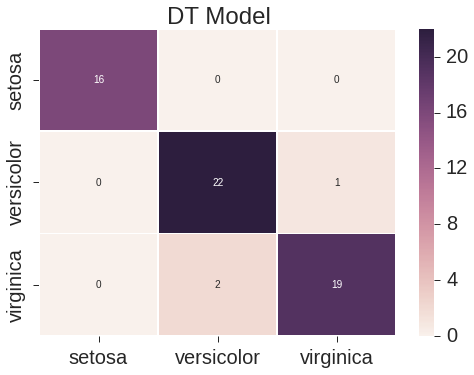

In [14]:
confusion(l_test, result, 'DT Model')

-----

## [Random Forest][rf]

The previous algorithms all perform well for this small test data set.
But in more complex data, an alternative approach has been shown to be
extremely powerful. This new technique is known as the random forest,
and this approach is built on the concept of ensemble learning. Ensemble
learning leverages the power of many weak learners to produce a more
accurate prediction. A classic example of ensemble learning is when a
crowd is asked to guess the number of marbles in a jar. While the
likelihood that any one person is correct is extremely small, the average
value of the crowd's predictions is generally remarkably close to the
true result.

A random forest implements this concept by building a set of decision
trees (i.e., a forest) that each use a randomly selected amount of the
total training data and training attributes to make a prediction. The
predictions from the different trees are statistically combined to make
a final prediction. With scikit-learn, we can easily apply a random
forest classifier, which is located in the `ensemble` module. Once again
we create our model, train the model, and subsequently use the model to
make predictions as demonstrated below.

-----

[rf]: https://en.wikipedia.org/wiki/Random_forest

In [15]:
# Next lets try Random Forests
from sklearn.ensemble import RandomForestClassifier

# Lets build our model and train it all at once
rfc = RandomForestClassifier(n_estimators=10, max_depth=None,
                             min_samples_split=1, random_state=0)

rfc.fit(d_train, l_train)

# Now grab the predictions
result = rfc.predict(d_test)

print("DT prediction accuracy = {0:5.1f}%".format(100.0 * rfc.score(d_test, l_test)))

DT prediction accuracy =  95.0%


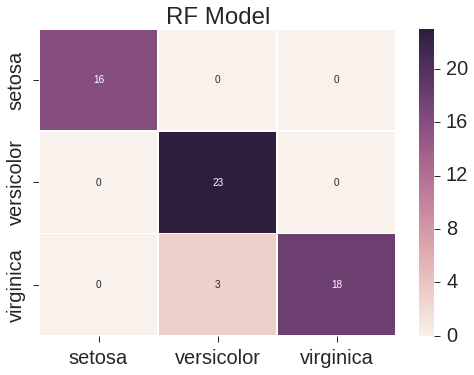

In [16]:
confusion(l_test, result, 'RF Model')

-----

### [Cross-Validation][cv]

So far we have simple quantified the performance of the different
algorithms by comparing their performance on a single test data. This
introduces a potential problem that certain training/testing data
combinations may preferentially work best with one type of algorithm. To
obtain a better characterization of the performance of a given
algorithm we can employ cross-validation, where we repeatedly select
different training and testing data sets from the original data and
accumulate the statistical measures of the performance for each new
sample. 

This technique can be easily applied to a pre-constructed scikit-lkearn
classification model by using the [`cross_val_score`][cvsl] method in the
`cross-validation` module. We demonstrate cross-validation by using our
SVC and Random Forest models, in this case we only use five
cross-validation samples.  For this simple data, the SVC outperforms the
random forest technique.

-----

[cv]: https://en.wikipedia.org/wiki/Cross-validation_(statistics)
[cvsl]: http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.cross_val_score.html#sklearn.cross_validation.cross_val_score




In [17]:
svm_scores = cross_validation.cross_val_score(clf, data, labels, cv=5)
rfc_scores = cross_validation.cross_val_score(rfc, data, labels, cv=5)

In [18]:
print("SVC CV Scores", svm_scores)
print("RFC CV Scores", rfc_scores)

SVC CV Scores [ 0.96666667  1.          0.96666667  0.96666667  1.        ]
RFC CV Scores [ 0.96666667  0.96666667  0.9         0.93333333  1.        ]


-----

## [Dimensionality Reduction][dr]

When confronted with a large, multi-dimensional data set, one approach to
simplify any subsequent analysis is to reduce the number of dimensions
that must be processed. In some cases, dimensions can be removed from
analysis based on business logic. More generally, however, we can
employ machine learning to seek out relationships between the original
dimensions (or attributes or columns of a DataFrame) to identify new
dimensions that better capture the inherent relationships within the
data.

The standard technique to perform this is known as principal component
analysis, or PCA. Mathematically,we can derive PCA by using linear
algebra to solve a set of linear equations. This process effectively
rotates the data into a new set of dimensions, and by ranking the
importance of the new dimensions, we can actually leverage fewer
dimensions in machine learning algorithms. PCA is demonstrated in the
following figure from Wikipedia, where we have a two-dimensional
Gaussian distribution. In the original space the data are widely spread.
By rotating into a coordinate system aligned with the Gaussian shape,
however, we have one primary dimension and a secondary dimension with
less spread.

![PCA Wikipedia Image][pcai]

We can easily implement PCA by using scikit-learn. The _PCA_ model
requires one tunable parameter that specifies the target number of
dimensions. This value can be arbitrarily selected, perhaps based on a
prior information, or it can be iteratively determined. After the model
is created, we fit the model to the data and next create our new,
rotated data set. This is demonstrated in the next code cell.

-----

[dr]: https://en.wikipedia.org/wiki/Dimensionality_reduction
[pca]: https://en.wikipedia.org/wiki/Principal_component_analysis
[pcai]: https://upload.wikimedia.org/wikipedia/commons/thumb/1/15/GaussianScatterPCA.png/512px-GaussianScatterPCA.png

In [19]:
# Principal Component Analysis
from sklearn.decomposition import PCA

# First create our PCA model
# For now we assume two compponents, to make plotting easier.
pca = PCA(n_components=2)

# Fit model to the data
pca.fit(data)

# Compute the transformed data (rotation to PCA space)
data_reduced = pca.transform(data)

# Need to modify to match number of PCA components
cols = ['PCA1', 'PCA2', 'Species']

# For example, if n_components = 3
# cols = ['PCA1', 'PCA2', 'PCA3', 'Species']

# Now create a new DataFrame to hold the results
# First a temporary np.array
tmp_d = np.concatenate((data_reduced, iris['species'].reshape((150, 1))), axis=1)

iris_pca = pd.DataFrame(tmp_d, columns = cols)

-----

Given the two new domensions, we can first see how they are related to
the original four dimensions (this isn't just a rotation since we
reduced the number of dimensions). We also can display the original
type-tagged data in a scatter plot that is now displayed by using the
principal components.

-----

In [20]:
# We can print out rotation matrix

c_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
for row in pca.components_:
    print(r" + ".join("{0:6.3f} * {1:s}".format(val, name) for val, name in zip(row, c_names)))

 0.361 * sepal_length + -0.085 * sepal_width +  0.857 * petal_length +  0.358 * petal_width
-0.657 * sepal_length + -0.730 * sepal_width +  0.173 * petal_length +  0.075 * petal_width


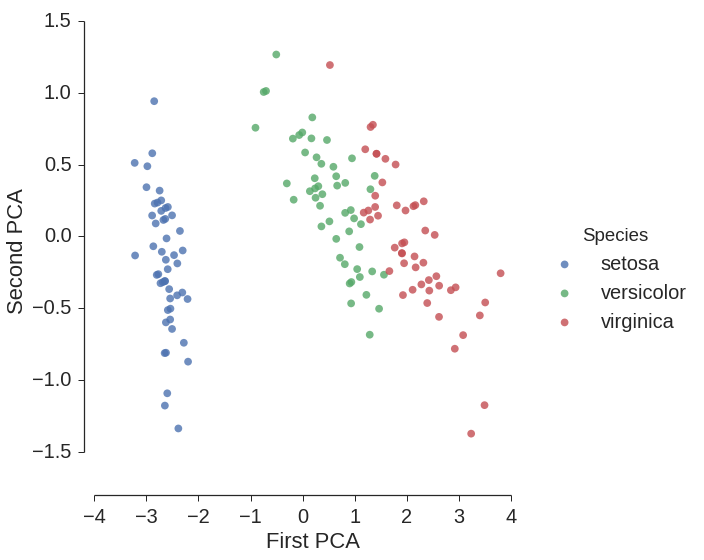

In [21]:
# Display the original data in the new space
splot_data('PCA1', 'PCA2', iris_pca, 'Species', 'First PCA', 'Second PCA', (-4.2, 4.6), (-1.8, 1.6))

-----

## [Clustering][cl]

The last machine learning technique we will explore is cluster finding.
Clustering seeks to first find $N$ clusters in a data set and to
subsequently identify which cluster data belong to. While there are a
number of different approaches to clustering, one of the easiest to
understand is the k-means algorithm. In this algorithm we start with a
guess for the number of clusters (again this can be based on a priori
information or iteratively quantified). We randomly place cluster
centers in the data and determine how well the data _cluster_ to these
cluster centers. This information is used to pick new cluster centers,
and the process continues until a solution converges (or we reach a
predefined number of iterations). This process is displayed in the
following figure from Wikipedia.

![KMeans Wikipedia Image][kmi]

We can employ k-means clustering with scikit-learn by using the `KMeans`
within the `cluster` module. This requires the number of clusters to
find as an input parameter. After the model is created, we once again
fit the model to the data and subsequently obtain our model predictions.
Note how this process is unsupervised in that we do not use the label
array in this process. After we find our clusters, we plot the original
data and the new clustered data in our principal component axes to
visually quantify how well the algorithm performed.

-----
[cl]: https://en.wikipedia.org/wiki/Cluster_analysis
[km]: https://en.wikipedia.org/wiki/K-means_clustering
[kmi]: images/kmeans-wikipedia.png

In [22]:
# We will use kmeans form scikit-learn

from sklearn.cluster import KMeans

# We build our model assuming three clusters
k_means = KMeans(n_clusters=3, random_state=0)

# We fit our data to assign classes
k_means.fit(data)

# Obtain the predictions
y_pred = k_means.predict(data)

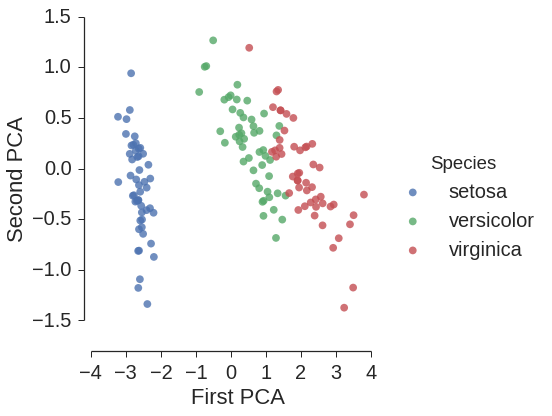

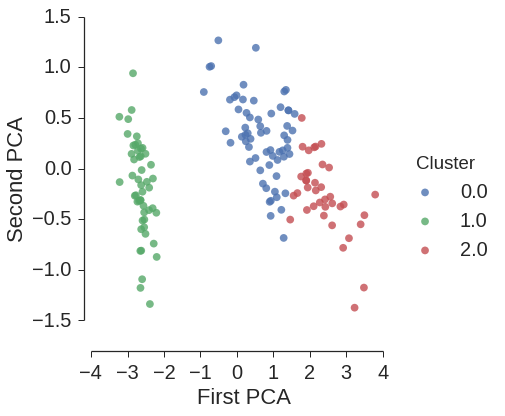

In [23]:
# Now we compare the cluster assignments to the real classes.

# Plot original data by using the principal components
splot_data('PCA1', 'PCA2', iris_pca, 'Species', 
           'First PCA', 'Second PCA', (-4.2, 4.6), (-1.8, 1.6), 6)

# Now we create the DataFrame from our predictions and the PCA components.
tmp_d = np.concatenate((data_reduced, y_pred.reshape((150, 1))), axis=1)
iris_clust = pd.DataFrame(tmp_d, columns = ['PCA1', 'PCA2', 'Cluster'])

# Plot k-means clusters by using the principal components
splot_data('PCA1', 'PCA2', iris_clust, 'Cluster', 
           'First PCA', 'Second PCA', (-4.2, 4.6), (-1.8, 1.6), 6)

-----

## Breakout Session: Data Formats

During this session, you should first try out as many examples in this
Notebook as you can. You also should have completed the tasks in the
first two lessons, as you will need the data in the Sflights HDF file.

### Intermediate Challenge:

Try out several of the basic classification techniques introduced above
on data in the slfights HDF file.

### Advanced Challenge:

Scikit-learn also supports regression algorithms that operate in a very
similar manner to the classification algorithms presented above. Read in
the sflights data and use SVM to develop a regression prediction between
departure delay and arrival delay. Try doing this for specific airports
like _ORD_ or _ATL_.

-----

### Additional References

-----

### Return to the [Week 7 Index](index.ipynb).

-----